In [1]:
import brightway2 as bw

## Select project, demand, method

In [2]:
bw.projects.set_current("EXIOBASE regionalized case study")

In [3]:
# Add methods if there are none
if len(bw.methods)==0:
    bw.create_default_lcia_methods()

In [4]:
# Copy existing `Oil seeds` database and name it `Independent oil`
if "Independent oil" in bw.databases: # if already exists, delete first
    del bw.databases['Independent oil']
bw.Database("Oil seeds").copy("Independent oil")

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 10/31/2019 22:35:43
  Finished: 10/31/2019 22:35:43
  Total time elapsed: 00:00:00
  CPU %: 104.30
  Memory %: 0.90


Brightway2 SQLiteBackend: Independent oil

In [5]:
bw.databases

Databases dictionary with 4 object(s):
	EXIOBASE 3.3.17 hybrid
	Independent oil
	Oil seeds
	biosphere3

In [6]:
# Select LCIA method
gwp = ('IPCC 2013', 'climate change', 'GWP 100a')

In [7]:
# Get access to the database `Independent oil`
db = bw.Database("Independent oil")

In [8]:
# Select random activity that has exchanges to see attributes of the exchanges
activity_with_exc_found = False
while not activity_with_exc_found:
    act = db.random()
    try: 
        exc = list(act.technosphere())[0]
        activity_with_exc_found = True
    except:
        pass

In [9]:
exc

Exchange: 1.0 kilogram 'Oil palm cultivation [FFB]' (kilogram, MY, None) to 'Palm oil mill [CPO]' (kilogram, MY, None)>

In [10]:
act.as_dict()

{'Category': '\\_5 Veg Oil case\\_food industry',
 'Comment': '',
 'name': 'Palm oil mill [CPO]',
 'kind': 'Material',
 'unit': 'kilogram',
 'database': 'Independent oil',
 'location': 'MY',
 'code': 'Palm oil mill [CPO]-MY'}

In [11]:
# Note that both input and output of an exchange are Activities (nodes of graph)
type(exc.input), type(exc.output), type(exc)

(bw2data.backends.peewee.proxies.Activity,
 bw2data.backends.peewee.proxies.Activity,
 bw2data.backends.peewee.proxies.Exchange)

In [12]:
# Check out all information in the exchange
exc.as_dict()

{'amount': 1.0,
 'name': 'Oil palm cultivation [FFB]',
 'unit': 'kilogram',
 'categories': (),
 'type': 'technosphere',
 'location': 'MY',
 'input': ('Independent oil', 'Oil palm cultivation [FFB]-MY'),
 'output': ('Independent oil', 'Palm oil mill [CPO]-MY')}

## Delete all exchanges that are linked to exiobase

In [13]:
# Total number of exchanges in db BEFORE separating db from exiobase
sum([len(list(ds.exchanges())) for ds in db])

894

In [14]:
for ds in db:
    for exc in ds.technosphere():
        if exc.input['database'] == 'EXIOBASE 3.3.17 hybrid':
            exc.delete()

In [15]:
# AFTER
sum([len(list(ds.exchanges())) for ds in db])

462

## Find activity with non-zero impact score

In [16]:
lca = bw.LCA({db.random(): 1}, gwp)
lca.lci()
lca.lcia()
lca.score

0.0

In [17]:
lca.demand

{'Landfill of bleaching earth' (ton, US, None): 1}

In [18]:
# Created technosphere matrix has only 266 activities
lca.technosphere_matrix

<266x266 sparse matrix of type '<class 'numpy.float64'>'
	with 424 stored elements in Compressed Sparse Row format>

Question: why are there fewer stored elements than number of exchanges?

In [19]:
# Find activity in `db` with non-zero impact score to run MC simulations with non-zero outputs
for act in db:
    if lca.score == 0:
        lca.redo_lcia({act: 1})
    else:
        break
lca.score

-1.808666589690446

In [20]:
# Corresponding demand
lca.demand

{'Palm kernel oil mill [Kernel processing]' (kilogram, MY, None): 1}

## Add uncertainty information to all exchanges. 

Uncertainty type 5 corresponds to triangular distribution.

Check out more in the stats_array library [here](https://stats-arrays.readthedocs.io/en/latest/).

In [21]:
for ds in bw.Database("Independent oil"):
    for exc in ds.technosphere():
        if exc['amount'] < 0:
            exc['uncertainty type'] = 5 
            exc['maximum'] = 0.75 * exc['amount']
            exc['minimum'] = 1.5 * exc['amount']
            exc['loc'] = exc['amount']
            exc.save()
        else:
            exc['uncertainty type'] = 5
            exc['minimum'] = 0.75 * exc['amount']
            exc['maximum'] = 1.5 * exc['amount']
            exc['loc'] = exc['amount']
            exc.save()            

## Create MonteCarloLCA object

In [22]:
lca.demand

{'Palm kernel oil mill [Kernel processing]' (kilogram, MY, None): 1}

In [23]:
mc = bw.MonteCarloLCA(lca.demand, gwp)

In [24]:
for _ in range(5):
    print(next(mc))

-2.54156574240819
-2.8193537283119285
-2.119216542176898
-2.1763423941923135
-1.4086301896469835


In [25]:
%%time
n_runs = 2700
values = [next(mc) for _ in range(n_runs)]

CPU times: user 8.52 s, sys: 24.3 ms, total: 8.54 s
Wall time: 7.73 s


## Let us plot a histogram of these values

In [26]:
import matplotlib.pyplot as plt

In [27]:
%matplotlib inline

(array([  1.,   0.,   2.,   5.,   7.,  14.,  20.,  34.,  67., 100., 166.,
        222., 315., 405., 414., 407., 310., 154.,  47.,  10.]),
 array([-5.32421168, -5.10299383, -4.88177598, -4.66055814, -4.43934029,
        -4.21812244, -3.99690459, -3.77568675, -3.5544689 , -3.33325105,
        -3.1120332 , -2.89081536, -2.66959751, -2.44837966, -2.22716181,
        -2.00594397, -1.78472612, -1.56350827, -1.34229043, -1.12107258,
        -0.89985473]),
 <a list of 20 Patch objects>)

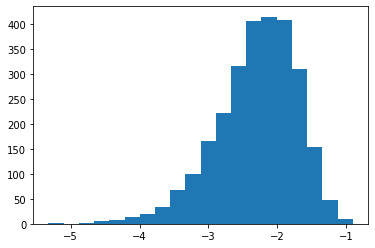

In [28]:
plt.hist(values, bins=20)

## Parallel Monte Carlo - run simulations on multiple workers to increase performance

In [29]:
# We can also create parallel Monte Carlo that will run simultations on multiple workers simultaneoulsy
# bw.ParallelMonteCarlo?

In [30]:
pmc = bw.ParallelMonteCarlo(mc.demand, mc.method, iterations=n_runs)

In [31]:
%%time
values = pmc.calculate()

CPU times: user 21.8 ms, sys: 46.3 ms, total: 68.2 ms
Wall time: 1.52 s


(array([  1.,   0.,   0.,   0.,   0.,   4.,  12.,  25.,  38.,  87., 125.,
        191., 296., 382., 435., 422., 348., 234.,  95.,  17.]),
 array([-5.57198638, -5.34103406, -5.11008175, -4.87912943, -4.64817711,
        -4.4172248 , -4.18627248, -3.95532016, -3.72436785, -3.49341553,
        -3.26246321, -3.0315109 , -2.80055858, -2.56960626, -2.33865395,
        -2.10770163, -1.87674931, -1.645797  , -1.41484468, -1.18389236,
        -0.95294004]),
 <a list of 20 Patch objects>)

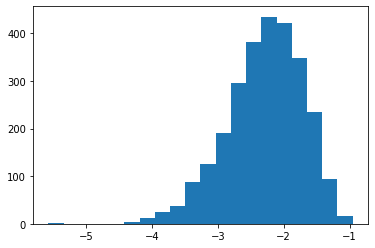

In [32]:
plt.hist(values, bins=20)